In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname  
!pwd  
import os
import sys

print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

oliva-titanrtx-2.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial  

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState


import optax

In [4]:
def smooth_curve(x, window, kernel='uniform'):
    assert len(x) > window and window % 2 == 1
    before, after = x[:window//2].mean(), x[-window//2:].mean()
    x = np.pad(x, (window//2, window//2), mode='constant', constant_values=(before, after))
    if kernel == 'uniform':
        kernel = np.ones(window)/window
    else:
        raise NotImplementedError
    return np.convolve(x, kernel, mode='valid')

In [5]:
class Agent(nn.Module):
    d_obs: int
    d_act: int

    @nn.compact
    def __call__(self, x):
        act = nn.Sequential([
            nn.Dense(64),
            nn.tanh,
            nn.Dense(64),
            nn.tanh,
            nn.Dense(self.d_act, kernel_init=nn.initializers.normal(stddev=0.01)),
        ])(x)
        return act


In [6]:
with open("/data/vision/phillipi/akumar01/synthetic-mdps-data/datasets/mujoco/HalfCheetah/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
d_obs, d_act = dataset['obs'].shape[-1], dataset['act_mean'].shape[-1]

In [7]:
def sample_batch(rng, dataset, batch_size):
    rng, _rng1, _rng2 = split(rng, 3)
    i_b = jax.random.randint(_rng1, (batch_size,), 0, dataset['obs'].shape[0])
    i_t = jax.random.randint(_rng2, (batch_size,), 0, dataset['obs'].shape[1])
    return jax.tree_map(lambda x: x[i_b, i_t], dataset)

In [47]:
rng = jax.random.PRNGKey(0)
agent = Agent(d_obs, d_act)
batch = sample_batch(rng, dataset, 1)

rng, _rng = split(rng)
agent_params = agent.init(_rng, jax.tree_map(lambda x: x[0], batch['obs']))

agent_forward = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0)))

def iter_step(state, batch):
    def loss_fn(params):
        act_pred = agent_forward(params, batch['obs'])
        return jnp.mean(jnp.square(act_pred - batch['act_mean']))
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    return state.apply_gradients(grads=grad), loss
iter_step = jax.jit(iter_step)

tx = optax.chain(#optax.clip_by_global_norm(1.),
                 optax.adamw(3e-4, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=agent.apply, params=agent_params, tx=tx)

pbar = tqdm(range(15000))
for i in pbar:
    rng, _rng = split(rng)
    batch = sample_batch(_rng, dataset, 32)
    train_state, loss = iter_step(train_state, batch)
    pbar.set_postfix({'loss': loss})

  0%|          | 0/15000 [00:00<?, ?it/s]

In [8]:
import gymnasium as gym
def make_env(env_id):
    def thunk():
        env = gym.make(env_id, ctrl_cost_weight=0)
        env = gym.wrappers.FlattenObservation(env)  # deal with dm_control's Dict observation space
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ClipAction(env)
        return env
    return thunk


In [33]:
envs = gym.vector.SyncVectorEnv( [make_env("HalfCheetah-v4") for i in range(64)] )

In [50]:
stats = []
obs, info = envs.reset()
for i in tqdm(range(1005)):
    act = agent_forward(train_state.params, obs)
    obs, rew, term, trunc, infos = envs.step(act)
    if "final_info" in infos:
        for info in infos["final_info"]:
            if info and "episode" in info:
                stats.append((info["episode"]["r"], info["episode"]["l"]))

  0%|          | 0/1005 [00:00<?, ?it/s]

In [51]:
np.array(stats)[:, 0].mean()

4542.3582191467285

In [10]:
def rollout_fn(train_state):
    envs = gym.vector.SyncVectorEnv( [make_env("HalfCheetah-v4") for i in range(64)] )
    stats = []
    obs, info = envs.reset()
    for i in tqdm(range(1005)):
        act = agent_forward(train_state.params, obs)
        obs, rew, term, trunc, infos = envs.step(act)
        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    stats.append((info["episode"]["r"], info["episode"]["l"]))
    return np.array(stats)[:, 0].mean()


In [ ]:
rng = jax.random.PRNGKey(0)
agent = Agent(d_obs, d_act)
batch = sample_batch(rng, dataset, 1)

rng, _rng = split(rng)
agent_params = agent.init(_rng, jax.tree_map(lambda x: x[0], batch['obs']))

agent_forward = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0)))

def iter_step(state, batch):
    def loss_fn(params):
        act_pred = agent_forward(params, batch['obs'])
        return jnp.mean(jnp.square(act_pred - batch['act_mean']))
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    return state.apply_gradients(grads=grad), loss
iter_step = jax.jit(iter_step)

tx = optax.chain(#optax.clip_by_global_norm(1.),
                 optax.adamw(3e-4, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=agent.apply, params=agent_params, tx=tx)

pbar = tqdm(range(6000))
losses, rets, iters = [], [], []
for i in pbar:
    if i%1000==0:
        ret = rollout_fn(train_state)
        rets.append(ret)
        iters.append(i)
        
    rng, _rng = split(rng)
    batch = sample_batch(_rng, dataset, 32)
    train_state, loss = iter_step(train_state, batch)
    pbar.set_postfix({'loss': loss})
    losses.append(loss)


2024-03-26 11:49:40.401263: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

In [36]:
losses, rets, iters = np.array(losses), np.array(rets), np.array(iters)

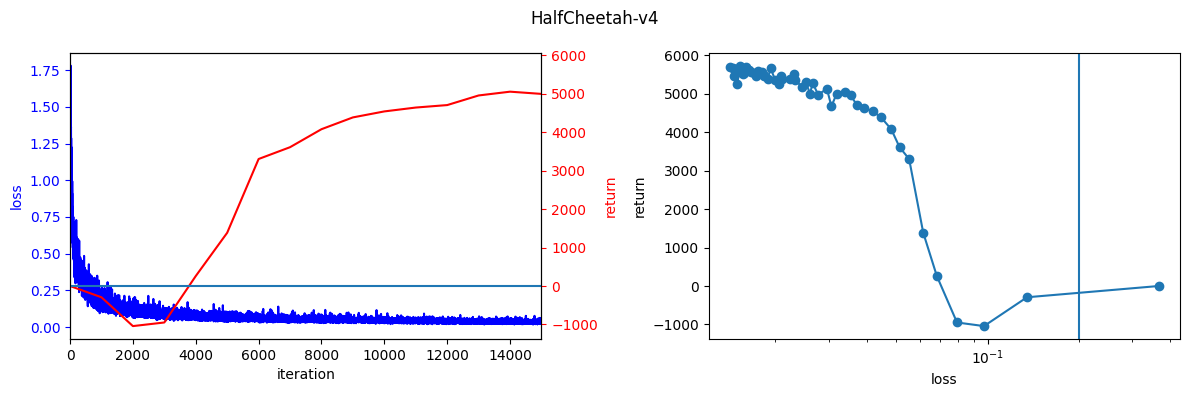

In [111]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# plot losses on one y axis and returns on another
ax1 = plt.gca()
ax1.plot(losses, 'b-')
ax1.set_xlabel('iteration')
ax1.set_ylabel('loss', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(iters, rets, 'r-')
ax2.set_ylabel('return', color='r')
ax2.tick_params('y', colors='r')
plt.axhline(0)

plt.xlim(0, 15000)

plt.subplot(1, 2, 2)
plt.plot(losses.reshape(-1, 1000).mean(axis=-1), rets)
plt.scatter(losses.reshape(-1, 1000).mean(axis=-1), rets)
plt.axvline(.2)
plt.xscale('log')
plt.ylabel('return')
plt.xlabel('loss')

plt.suptitle("HalfCheetah-v4")
plt.tight_layout()
plt.show()



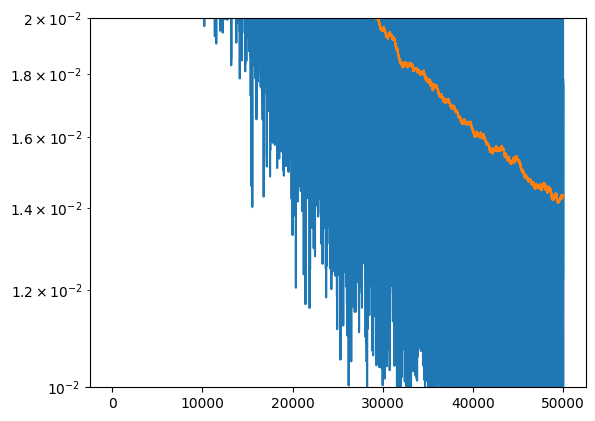

In [108]:
plt.plot(losses)
plt.plot(smooth_curve(losses, 1001))
plt.ylim(1e-2, 2e-2)
plt.yscale('log')